# Eater creation

My sexy eater for **Cogntivie Portrait** challenge!

Using principes from [Source](CognitivePortrait.ipynb)

In [1]:
import sys
!{sys.executable} -m pip install --quiet --user -r requirements.txt
import cv2
import matplotlib.pyplot as plt
import glob, os
import time

<span style="color:orange">Tap your Face-API key and endpoint here!<span>

In [2]:
key = ''
endpoint = 'https://westcentralus.api.cognitive.microsoft.com' 
# You might need different endpoint, check the cognitive services page!

In [3]:
import azure.cognitiveservices.vision.face as cf
from msrest.authentication import CognitiveServicesCredentials
cli = cf.FaceClient(endpoint,CognitiveServicesCredentials(key))

## Getting Some Images

Tap your images path here for use the magic!

In [4]:
path = 'images/gates/*'

This code loads images from path. Let's save the images into `images` array, and face-api landmarks data into `imagepoints`!

Our party is closed and sad people can't come in! Strictly Face Control!

In [5]:
def imread(fn):
    im = cv2.imread(fn)
    return cv2.cvtColor(im,cv2.COLOR_BGR2RGB) if im is not None else None

fnames = glob.glob(path)

filenames = []
images = []
imagepoints = []
smiles = []
#cli.face.detect_with_url('https://soshnikov.com/images/official/shwars_geek.jpg')
for fn in fnames:
    print("Processing {}".format(fn))
    with open(fn,'rb') as f:
        try:
            res = cli.face.detect_with_stream(f,return_face_landmarks=True, return_face_attributes=['smile'])
        except:
            time.sleep(45)
    if len(res)>0 and res[0].face_attributes.smile > 0.8:
        filenames.append(fn)
        images.append(imread(fn))
        smiles.append((res[0].face_attributes.smile - 0.85) / 0.15)
        imagepoints.append(res[0].face_landmarks.as_dict())

Processing images/gates/gates_40.jpg
Processing images/gates/gates_2.jpg
Processing images/gates/gates_28.jpg
Processing images/gates/gates_45.jpg
Processing images/gates/gates_19.jpg
Processing images/gates/gates_7.jpg
Processing images/gates/gates_14.jpg
Processing images/gates/gates_26.jpg
Processing images/gates/gates_31.jpg
Processing images/gates/gates_22.jpg
Processing images/gates/gates_8.jpg
Processing images/gates/gates_17.jpg
Processing images/gates/gates_35.jpg
Processing images/gates/gates_39.jpg
Processing images/gates/gates_33.jpg
Processing images/gates/gates_37.jpg
Processing images/gates/gates_0.jpg
Processing images/gates/gates_25.jpg
Processing images/gates/gates_34.jpg
Processing images/gates/gates_21.jpg
Processing images/gates/gates_23.jpg
Processing images/gates/gates_16.jpg
Processing images/gates/gates_11.jpg
Processing images/gates/gates_38.jpg
Processing images/gates/gates_1.jpg
Processing images/gates/gates_9.jpg
Processing images/gates/gates_10.jpg
Process

In [6]:
print("We choose", len(images), "images for best funny portret!")

We choose 22 images for best funny portret!


I want to see this!

In [7]:
def display_images(l):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

![1](images/to_reprt/1.jpg)

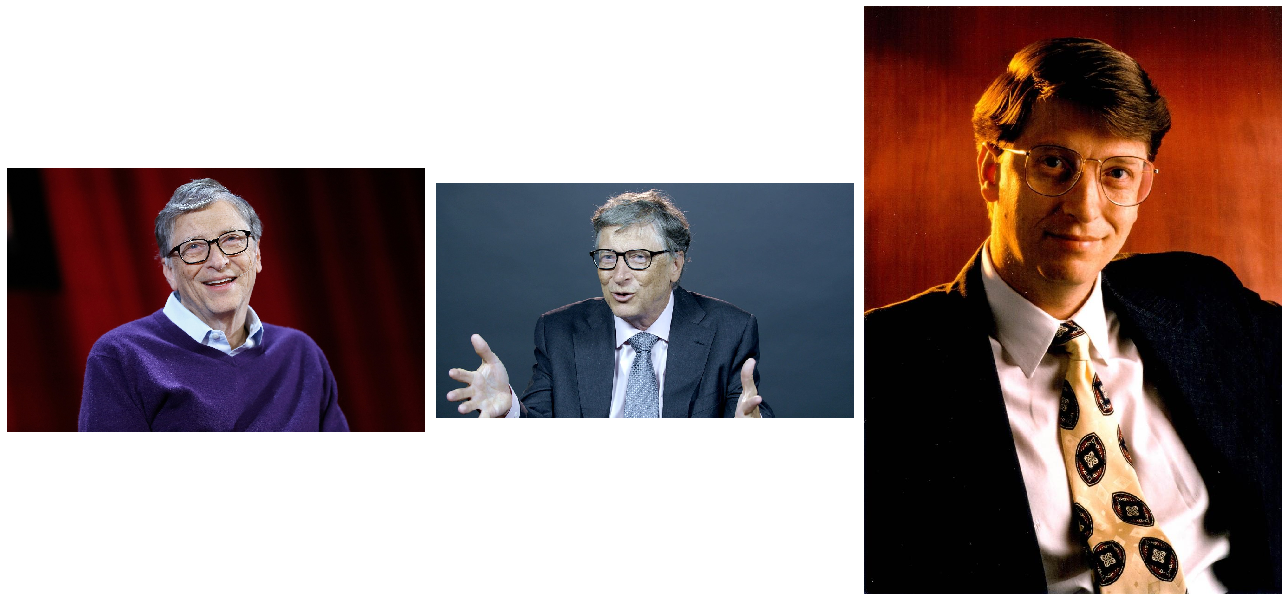

In [8]:
display_images(images[2:5])

## Affine Transformations

For union our photos in real one we want to define standpoints of concatenation. This will our eyes and middle of mouth! This  standpoints shoud be on same positions of photo.

We will use standart coords for this deal!

The function to rotate our images to the fixes eyes-mouth position:

In [9]:
import numpy as np

target_triangle = np.float32([[130.0,120.0],[170.0,120.0],[150.0,160.0]])
size = 300

def affine_transform(img,attrs):
    mc_x = (attrs['mouth_left']['x']+attrs['mouth_right']['x'])/2.0
    mc_y = (attrs['mouth_left']['y'] + attrs['mouth_right']['y']) / 2.0
    tr = cv2.getAffineTransform(np.float32([(attrs['pupil_left']['x'],attrs['pupil_left']['y']),
                                            (attrs['pupil_right']['x'],attrs['pupil_right']['y']),
                                            (mc_x,mc_y)]), target_triangle)
    # compute coords of some parts of face for change in future
    to_change = {}
    to_change['mouth'] = (
        # left top cut angle coords
        np.dot(tr, np.float32((attrs['mouth_left']['x'], attrs['mouth_left']['y'], 1)))[0],
        np.dot(tr, np.float32((attrs['upper_lip_top']['x'], attrs['upper_lip_top']['y'], 1)))[1],
        # right bottom angle coords
        np.dot(tr, np.float32((attrs['mouth_right']['x'], attrs['mouth_right']['y'], 1)))[0],
        np.dot(tr, np.float32((attrs['under_lip_bottom']['x'], attrs['under_lip_bottom']['y'], 1)))[1],
    )
    to_change['left_eye'] = tuple(
        # right side
        np.dot(tr, np.float32((attrs['nose_root_left']['x'], attrs['nose_root_left']['y'], 1)))
    )
    to_change['right_eye'] = tuple(
        # left side coords
        np.dot(tr, np.float32((attrs['nose_root_right']['x'], attrs['nose_root_right']['y'], 1)))
    )
    return cv2.warpAffine(img,tr,(size,size)), to_change

![People Blending](images/to_reprt/2.jpg)

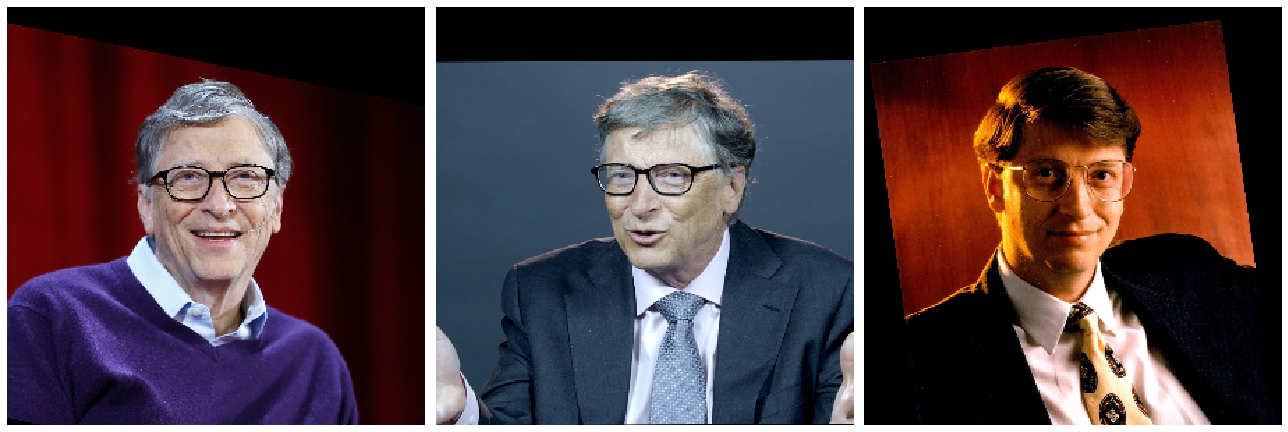

In [10]:
trans_result = [affine_transform(i,a) for i,a in zip(images,imagepoints)]
img_aligned = list(map(lambda x: x[0], trans_result))
display_images(img_aligned[2:5])

Shaken, not stirred!

## Let's the Fun Begin!

Cut our mouth from image and attach right/left side of mouth to NoseRootLeft/NoseRootRight. Perfect Crime!

In [11]:
def eyes_to_mouth(img, attrs):
    ans = np.array(img)
    # get attrs coords
    mouth_coords = tuple(map(int, attrs['mouth']))
    left_eye_coords = tuple(map(int, attrs['left_eye']))
    right_eye_coords = tuple(map(int, attrs['right_eye']))
    
    # get mouth img
    mouth = img[mouth_coords[1]:mouth_coords[3]+1,
                mouth_coords[0]:mouth_coords[2]+1]
    # compute params
    mouth_width = mouth_coords[2] - mouth_coords[0] + 1
    mouth_height = mouth_coords[3] - mouth_coords[1] + 1
    
    # change left eye to mouth
    eye_bot = left_eye_coords[1] - mouth_height // 2
    eye_top = left_eye_coords[1] + mouth_height - mouth_height // 2
    ans[np.ix_(np.arange(eye_bot, eye_top),
               np.arange(left_eye_coords[0] - mouth_width, left_eye_coords[0]))] = mouth
    left_eye = img[left_eye_coords[1] - mouth_width:left_eye_coords[1]+1,
                left_eye_coords[0] - mouth_height:left_eye_coords[0]+1]
    #change right eye to mouth
    eye_bot = right_eye_coords[1] - mouth_height // 2
    eye_top = right_eye_coords[1] + mouth_height - mouth_height // 2
    ans[np.ix_(np.arange(eye_bot, eye_top),
               np.arange(right_eye_coords[0], right_eye_coords[0] + mouth_width))] = mouth
    
    return ans

In [12]:
img_eater = list(map(lambda t: eyes_to_mouth(*t), trans_result))

![3](images/to_reprt/3.jpg)

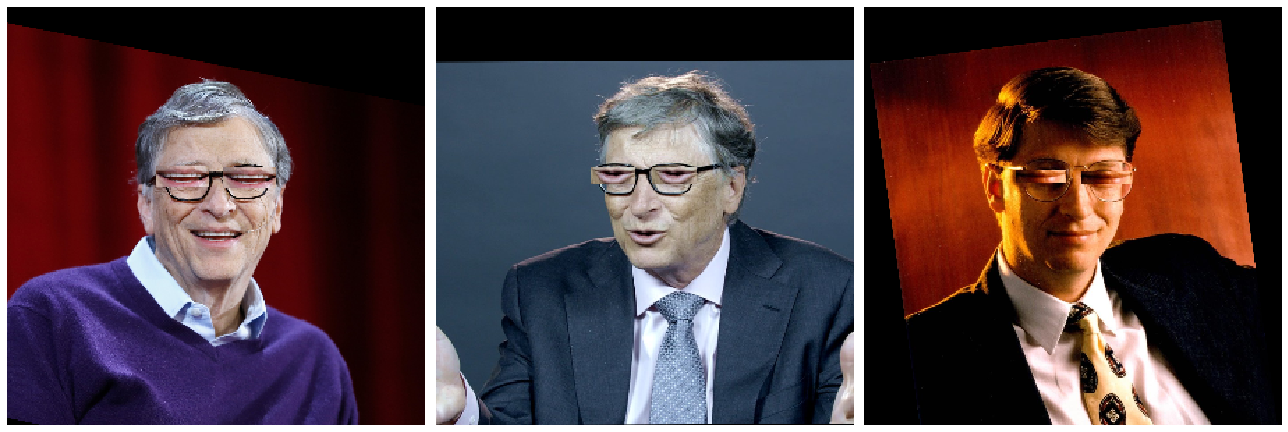

In [13]:
display_images(img_eater[2:5])

We will change eyes with a mouth on all aligned photos for create ideal man!

## Image Blending

To blend images together, we just calculate the average with a weights by a smile rate:

In [14]:
def merge(images,wts=None):
    res = np.zeros_like(images[0],dtype=np.float32)
    if wts is None:
        wts = np.ones(len(images))
    wts /= np.sum(wts)
    for n,i in enumerate(images):
        res += wts[n]*i.astype(np.float32)
    return res.astype(np.ubyte)

Now let's merge all aligned images altogether and see what happens:

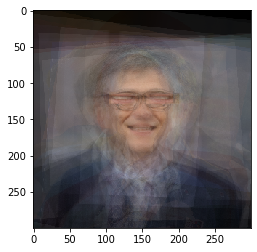

In [15]:
res = merge(img_eater, smiles)
plt.imshow(res)

## Saving the result

Saving our sexy boy for a long time! Enjoy the magic!

In [16]:
cv2.imwrite('results/eater.jpg',cv2.cvtColor(res,cv2.COLOR_BGR2RGB))

True

<center><h5>Made by Max Bronnikov</h5></center>